In [ ]:
from google.colab import drive
drive.mount("/content/drive",force_remount=True)

Mounted at /content/drive


In [ ]:
!pip install fasttext-langdetect

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.8/68.8 KB 8.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Using cached pybind11-2.10.4-py3-none-any.whl (222 kB)
  Created wheel for fasttext-langdetect: filename=fasttext_langdetect-1.0.5-py3-none-any.whl size=7521 sha256=7f0e575237368f6977eb141fa69b4e2082bbb651108bf86ebedc5843552a085b
  Stored in directory: /root/.cache/pip/wheels/1b/0b/90/a4681c284d9a0da966cb7b6c378836cd3b0c9f23dc9ec7dfc5
  Created wheel for fasttext: filename=fasttext-0.9.2-cp39-cp39-linux_x86_64.whl size=4395536 sha256=0c0d721a663d55b83558ca39f65d14d1ba07fb5bee437ff35520323001106970
  Stored in directory: /root/.cache/pip/wheels/64/57/bc/1741406019061d5664914b070bd3e71f6244648732bc96109e
Successfully built fasttext-langdetect fasttext


In [ ]:

import pandas as pd
import numpy as np
import re

from ftlangdetect import detect

import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

import spacy
nlp=spacy.load("en_core_web_sm")

import os 
from nltk import ngrams
from collections import Counter
import tqdm

import nltk 
from nltk import ngrams
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

nltk.download("punkt")
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [ ]:
#Using zipfile to extract JSON files from the .zip file
import zipfile
zip_ref = zipfile.ZipFile("/content/drive/My Drive/pdf_json.zip", 'r')
zip_ref.extractall("/content/files/")
zip_ref.close()

In [ ]:
#Function to extract the text from the JSON files
import json
def extract_body_text(filename):
  file1 = open(filename)
  paper_content = json.load(file1)
  abstract = ""
  if "abstract" in paper_content :
    for bt in paper_content ["abstract"]:
      abstract = abstract + bt["text"]
  return ( abstract + '\n').lower()

In [ ]:
#Function for performing text preprocessing
#Preprocessing includes case folding, removing punctuations and lemmatization
def preprocessing(text):
  res=""

  #Converting corpus to lower case
  text=text.lower()

  #Removing references
  text=re.sub("\[\d+\]"," ",text)

  #Removing punctuations
  text=re.sub("""\.|\,|\$|-|\#|\^|\(|\)|\-|#|@|\'|\+|\"|\/|\;|\:|\%|\=|\*"""," ",text)

  #Removing multiple occurences of space with a single space
  text=re.sub("\s*\s"," ",text)
  
  return text


In [ ]:
tokens=[]
for j in tqdm.tqdm(os.listdir("files/pdf_json/")[:100]):
    try:
      text=preprocessing(extract_body_text(f'files/pdf_json/{j}'))

      #Detecting the language of the text
      lang=detect(text,low_memory=False)

      if lang["lang"]=="en":

        words=text.split(" ")

        words=[i for i in words if i!='']

        tokens.extend(words)

    except UnicodeDecodeError:
      pass

100%|██████████| 100/100 [00:01<00:00, 67.35it/s]


In [ ]:
len(tokens)

11738

In [ ]:
#Creating sequences of words of length 25, i.e., for every sequence of 25 words, the 26th word is the output at that timestep
word_sequences=[]

train_len=25 + 1

for i in range(train_len,len(tokens)):
  w=tokens[i-train_len:i]
  word_sequences.append(w)

<b>ENCODING THE SENTENCES</b>

In [ ]:
import keras
from keras.preprocessing.text import Tokenizer

In [ ]:
#Using Tensorflow tokenizer object for encoding
tokenizer=Tokenizer()

In [ ]:
#Fitting the object on the word sequences
tokenizer.fit_on_texts(word_sequences)

In [ ]:
sequences=tokenizer.texts_to_sequences(word_sequences)

In [ ]:
#Making a matrix of the encoded word sequences
sequences=np.array(sequences)
sequences

array([[ 674,   13, 3347, ...,    2,  672,   44],
       [  13, 3347,    5, ...,  672,   44,   25],
       [3347,    5,    1, ...,   44,   25,  150],
       ...,
       [3336,   25, 3337, ...,    1,  495,    2],
       [  25, 3337, 1556, ...,  495,    2, 3348],
       [3337, 1556,    1, ...,    2, 3348, 3349]])

In [ ]:
vocab_size=len(tokenizer.word_counts)

In [ ]:
vocab_size

3079

In [ ]:
#importing the layers to build an RNN
import keras
from keras.models import Sequential
from keras.layers import Embedding,LSTM,Dense
     

<h4>Changed number of neurons to 150 to improve accuracy.</h4>

In [ ]:
#creating the RNN with 2 LSTM layers

def create_model(vocabulary_size, seq_len):
    model = Sequential()
    model.add(Embedding(vocabulary_size, 25, input_length=seq_len))
    model.add(LSTM(150, return_sequences=True))
    model.add(LSTM(150))
    model.add(Dense(150, activation='relu'))

    model.add(Dense(vocabulary_size, activation='softmax'))
    
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
   
    model.summary()
    
    return model

In [ ]:
#Splitting the matrix into input sequences and labels
from tensorflow.keras.utils import to_categorical

X=sequences[:,:-1]
y=sequences[:,-1]
y=to_categorical(y,num_classes=vocab_size+1)

In [ ]:
X.shape,y.shape

((13075, 25), (13075, 3350))

In [ ]:
seq_len=X.shape[1]

In [ ]:
model=create_model(vocab_size+1,seq_len)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 25, 25)            77000     
                                                                 
 lstm (LSTM)                 (None, 25, 150)           105600    
                                                                 
 lstm_1 (LSTM)               (None, 150)               180600    
                                                                 
 dense (Dense)               (None, 150)               22650     
                                                                 
 dense_1 (Dense)             (None, 3080)              465080    
                                                                 
Total params: 850,930
Trainable params: 850,930
Non-trainable params: 0
_________________________________________________________________


<h4>Changed the number of epochs from 150 to 200 to increase accuracy from 76% to 98%</h4>

In [ ]:
history=model.fit(X, y, batch_size=128, epochs=200,verbose=1)

Epoch 1/200
92/92 [==============================] - 33s 210ms/step - loss: 7.2734 - accuracy: 0.0399
Epoch 2/200
92/92 [==============================] - 9s 94ms/step - loss: 6.8722 - accuracy: 0.0450
Epoch 3/200
92/92 [==============================] - 7s 69ms/step - loss: 6.8171 - accuracy: 0.0465
Epoch 4/200
92/92 [==============================] - 2s 23ms/step - loss: 6.6939 - accuracy: 0.0464
Epoch 5/200
92/92 [==============================] - 2s 26ms/step - loss: 6.6082 - accuracy: 0.0565
Epoch 6/200
92/92 [==============================] - 2s 25ms/step - loss: 6.5131 - accuracy: 0.0614
Epoch 7/200
92/92 [==============================] - 5s 50ms/step - loss: 6.4052 - accuracy: 0.0630
Epoch 8/200
92/92 [==============================] - 4s 41ms/step - loss: 6.2978 - accuracy: 0.0657
Epoch 9/200
92/92 [==============================] - 2s 19ms/step - loss: 6.1940 - accuracy: 0.0692
Epoch 10/200
92/92 [==============================] - 3s 28ms/step - loss: 6.0991 - accuracy: 0.06

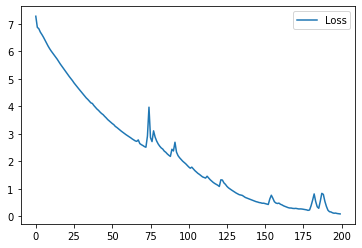

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.history["loss"],label="Loss")
plt.legend()
plt.show()

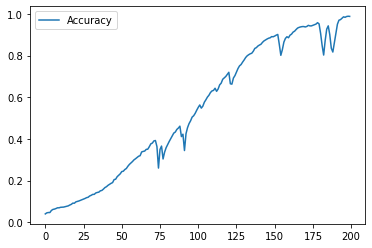

In [ ]:
plt.plot(history.history["accuracy"],label="Accuracy")
plt.legend()
plt.show()

In [ ]:
#model.save("text_gen.h5")

In [ ]:
#model = keras.models.load_model('/content/drive/MyDrive/text_gen.h5')

In [ ]:
from random import randint
from tensorflow.keras.preprocessing.sequence import pad_sequences

<b>DECODING</b>

In [ ]:
#Generate new text
def generate_text(model, tokenizer, seq_len, seed_text, num_gen_words):
    
    # Final Output
    output_text = []
    
    # Intial Seed Sequence
    input_text = seed_text
    
    # Create num_gen_words
    for i in range(num_gen_words):
        
        # Take the input text string and encode it to a sequence
        encoded_text = tokenizer.texts_to_sequences([input_text])[0]
        
        # Pad sequences to our trained rate (50 words in the video)
        pad_encoded = pad_sequences([encoded_text], maxlen=seq_len, truncating='pre')
        
        # Predict Class Probabilities for each word
        pred_word_ind = np.argmax(model.predict(pad_encoded, verbose=0)[0])
        
        # Grab word
        pred_word = tokenizer.index_word[pred_word_ind] 
        
        # Update the sequence of input text (shifting one over with the new word)
        input_text += ' ' + pred_word
        
        output_text.append(pred_word)
        
    # Make it look like a sentence.
    return ' '.join(output_text)
     

In [ ]:
#Sample sentences for output generation
sents=[]
for j in tqdm.tqdm(os.listdir("files/pdf_json/")[1000:1010]):
    try:
      text=preprocessing(extract_body_text(f'files/pdf_json/{j}'))

      #Detecting the language of the text
      lang=detect(text,low_memory=False)

      if lang["lang"]=="en":
        sents.append(text)
    except: 
      pass

100%|██████████| 10/10 [00:00<00:00, 179.82it/s]


In [ ]:
for sent in sents:
    inp=" ".join(sent.split(" ")[:10])
    out=generate_text(model,tokenizer,seq_len,seed_text=inp,num_gen_words=50)

    print("Actual sentence ---",sent)
    print("Generated sentence ---",out)
    print("\n")
    print("*******************************************************************")
    print("\n")

Actual sentence ---  
Generated sentence --- <6 49 log 10 depression beck depression inventory and hiv completely prokaryotic and social network notably are no restraint free care icu atom fold coordinated c atom connected in the specified order to we further via the efficacy for the precipitate after magnetic separation was measured at the excitation wavelength


*******************************************************************


Actual sentence --- covid 19 has spread to most countries in the world puzzlingly the impact of the disease is different in different countries these differences are attributed to differences in cultural norms mitigation efforts and health infrastructure here we propose that national differences in covid 19 impact could be partially explained by the different national policies respect to bacillus calmette guérin bcg childhood vaccination bcg vaccination has been reported to offer broad protection to respiratory infections we compared large number of countri